# Guam Carona Virus Data from Johns Hopkins

## Data Source

Data are sourced from a [GitHub data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).

## Current Status

When I started this project, grabbing the data was as easy as downloading a single CSV file, **time_series_covid19_confirmed_global.csv**. Unfortunately, the data mainainers decided to remove US state and county-level entries from this file (See https://github.com/CSSEGISandData/COVID-19/issues/1250#issue-585788363).
Grabbing the raw data is now a lot more difficult. My **workaround** function contains code which I am using as a temporary work-around until restructuring of the JHU CSSEE data repo is completed. This code comes from https://github.com/CSSEGISandData/COVID-19/issues/1250#issuecomment-604561039.

In [1]:
%matplotlib inline
import requests
import datetime
import pandas as pd
import matplotlib
import os
import numpy as np
import time

In [2]:
def days_since_file_modified(filepath):
    return (time.time() - os.path.getmtime(filepath))/(3600*24)

In [3]:
def workaround():
    """
    Downloads raw data from github.com/CSSEGISandData/COVID-19.
    
    I currently need only one of the dataframes defined here, so this is the only one returned: dfConfirmedUSStates
    
    This function contians contains code which I am using as a temporary work-around until restructuring of the 
    JHU CSSEE data repo is completed. This code comes from 
    https://github.com/CSSEGISandData/COVID-19/issues/1250#issuecomment-604561039.
    """

    # Read all the files
    dfConfirmedGlobal = pd.read_csv(r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    dfDeathsGlobal = pd.read_csv(r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

    baseURLFormat = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'
    filePaths = [baseURLFormat.format(d.strftime('%m-%d-%Y')) for d in pd.date_range('2020-03-23', pd.to_datetime('today')).tolist()]

    df_from_each_file = []
    for f in filePaths:
        try:        
            df_from_each_file.append(pd.read_csv(f))
        except:
            break
    dfByDay = pd.concat(df_from_each_file, ignore_index=True)

    dfConfirmedUS = pd.read_csv(r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-Confirmed_archived_0325.csv')
    dfConfirmedUS = dfConfirmedUS[dfConfirmedUS.columns[:-1]]
    dfDeathsUS = pd.read_csv(r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/archived_data/archived_time_series/time_series_19-covid-Deaths_archived_0325.csv')
    dfDeathsUS = dfDeathsUS[dfDeathsUS.columns[:-1]]

    # Get US data only
    dfConfirmedUS = dfConfirmedUS [(dfConfirmedUS['Country/Region'] == 'US') & (dfConfirmedUS['Province/State'] != 'US')]
    dfDeathsUS = dfDeathsUS [(dfDeathsUS['Country/Region'] == 'US') & (dfDeathsUS['Province/State'] != 'US')]

    # Merge columns after 3/23 when the timeseries broke
    dfByDayState = dfByDay[dfByDay.Country_Region == 'US'].groupby(['Last_Update', 'Province_State']).agg({'Confirmed':sum, 'Deaths':sum}).unstack(level=0)
    dfByDayStateConfirmed = dfByDayState[['Confirmed']]
    dfByDayStateConfirmed.columns = dfByDayStateConfirmed.columns.droplevel().map(lambda x: pd.to_datetime(x).strftime('%#m/%d/%y'))

    dfConfirmedUSStates = dfConfirmedUS.merge(dfByDayStateConfirmed, how='left', left_on='Province/State', right_on='Province_State')
    dfConfirmedUSStates[dfConfirmedUSStates.columns[4:]] = dfConfirmedUSStates[dfConfirmedUSStates.columns[4:]].fillna(0).astype(np.int64)
    dfConfirmedUSStates = dfConfirmedUSStates.sort_values(dfConfirmedUSStates.columns[-1], ascending = False)

    dfByDayStateDeaths = dfByDayState[['Deaths']]
    dfByDayStateDeaths.columns = dfByDayStateDeaths.columns.droplevel().map(lambda x: pd.to_datetime(x).strftime('%#m/%d/%y'))
    dfDeathsUSStates = dfDeathsUS.merge(dfByDayStateDeaths, how='left', left_on='Province/State', right_on='Province_State')
    dfDeathsUSStates[dfDeathsUSStates.columns[4:]] = dfDeathsUSStates[dfDeathsUSStates.columns[4:]].fillna(0).astype(np.int64)
    dfDeathsUSStates = dfDeathsUSStates.sort_values(dfDeathsUSStates.columns[-1], ascending = False)

    # Use dfConfirmedUSStates and dfDeathsUSStates
    
    return dfConfirmedUSStates

In [4]:
def download_and_save_raw_data(raw_data_file):
    """
    Download raw data as a CSV file from the Johns Hopkins GitHub repo and store it in a disk file.
    """
    df = workaround()
    df.to_csv(raw_data_file, index=False)

In [5]:
def get_data(raw_data_file, place_name):
    """
    Returns a data frame containing dates as an index and number of confirmed cases (cumulative) as a single column.
    A copy of the data frame is saved to disk as a CSV file.
   
    Note: I found it easier to do the wrangling in a text representation of the CSV file rather than using 
    pandas methods. 
    """
    
    # Read raw_data_file CSV as a list of strings
    with open (raw_data_file, "r") as myfile:
        csv = myfile.read().split('\n')

    # Column titles will be used as the index for the new dataframe    
    column_titles = csv[0].split(',')

    # Find the first line containing place_name as a substring
    for line in csv:
        if place_name in line:
            data = line
            break
    data = data.split(',')

    # Create a dict where key is dates and a single column is contains number of confirmed cases
    data_dict = {}
    for item in zip(column_titles, data):
        if item[1].isdigit():
            cases = int(item[1])
            if cases > 0:
                mdy = item[0].split('/')
                date = datetime.datetime(year=2000 + int(mdy[2]), month=int(mdy[0]), day=int(mdy[1]))
                data_dict[date] = cases

    # Convert the dict to a data frame
    df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['cases'])
    df.sort_index(inplace=True)
    
    # Save df to a csv file
    df.to_csv('{}.csv'.format(place_name))
    
    return df

#get_data('ConfirmedUSStates.csv', 'Guam')

In [6]:
def plot_data(raw_data_file, place_name):
    """
    Plots data in this notebook and also writes the plot to a PNG file.
    """
    df = get_data(raw_data_file, place_name)
    plot = df.plot(style='o', title='Confirmed CORVID19 cases in {}'.format(place_name))    
    fig = plot.get_figure()
    fig.savefig('images/{}.png'.format(place_name), bbox_inches='tight')
        
#plot_data('ConfirmedUSStates.csv', 'Guam')
#plot_data('ConfirmedUSStates.csv', 'Hawaii')

# MAIN

Refreshing ConfirmedUSStates.csv


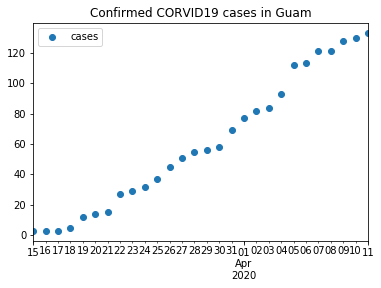

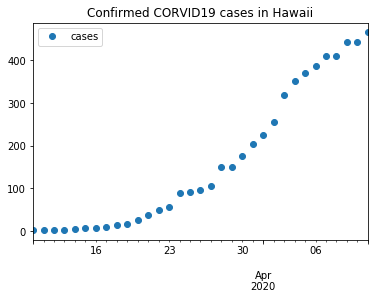

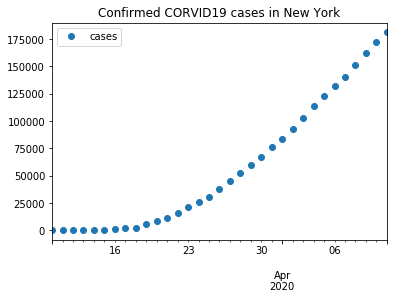

In [7]:
raw_data_file = 'ConfirmedUSStates.csv'

#if days_since_file_modified(raw_data_file) > 0.5:
print('Refreshing {}'.format(raw_data_file))
download_and_save_raw_data(raw_data_file)
    
# Plot data for places of interest in the US
plot_data(raw_data_file, 'Guam')  
plot_data(raw_data_file, 'Hawaii')
plot_data(raw_data_file, 'New York')